
Model Performance Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        34

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

     DaysSinceLastTransaction  SatisfactionScore  RecommendationLikelihood  \
122                        32                  6                         1   
105                        39                  7                         5   
85                         20                  7                         6   
45                         32                  6                         5   
70                          6                  1                         6   

     Churn  Scored Labels  Scored Probabilities  
122      1              1                  1.00  
105      1

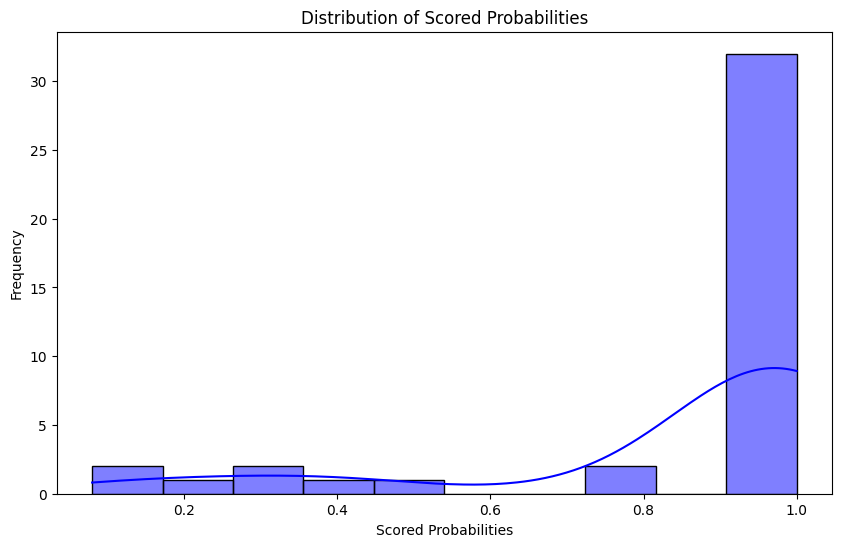

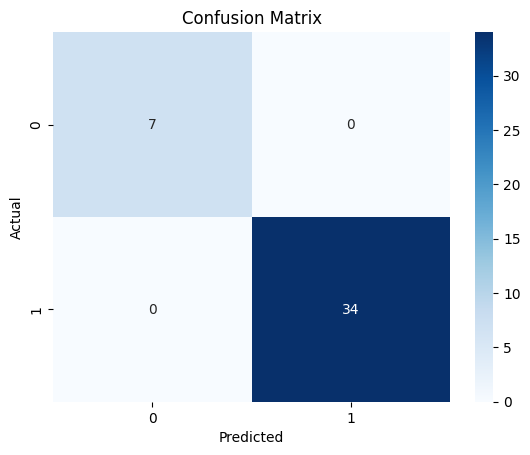

In [3]:
# Importera nödvändiga bibliotek
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Läs in datasets
market_research = pd.read_csv('market_research.csv')  # Marknadsundersökning
transactions = pd.read_csv('transactions.csv')       # Transaktionsdata

# Konvertera TransactionDate till datetime-format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Beräkna senaste transaktionsdatum för varje kund
last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerID', 'LastTransactionDate']

# Begränsa analysen till kunder som finns i båda datasets
common_customers = market_research.merge(last_transaction, on='CustomerID', how='inner')

# Beräkna DaysSinceLastTransaction för matchade kunder
today = pd.to_datetime("2023-02-15")
common_customers['DaysSinceLastTransaction'] = (today - common_customers['LastTransactionDate']).dt.days

# Skapa kolumn för Churn baserat på regler
common_customers['Churn'] = common_customers.apply(
    lambda row: 1 if row['DaysSinceLastTransaction'] > 30 or 
                      row['SatisfactionScore'] < 5 or 
                      row['RecommendationLikelihood'] < 5 else 0,
    axis=1
)

# Funktioner och målvariabel
X = common_customers[['DaysSinceLastTransaction', 'SatisfactionScore', 'RecommendationLikelihood']]
y = common_customers['Churn']

# Dela upp data i tränings- och testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Skapa och träna Random Forest-modellen
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Gör förutsägelser och hämta sannolikheter
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # Sannolikheter för klass 1 (Churn)

# Utvärdering av modellen
print("\nModel Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Skapa en DataFrame för resultat
results = X_test.copy()
results['Churn'] = y_test.values
results['Scored Labels'] = predictions
results['Scored Probabilities'] = probabilities

# Visa de första raderna i resultatet
print(results.head())

# Visualisera sannolikhetsfördelningen
plt.figure(figsize=(10, 6))
sns.histplot(results['Scored Probabilities'], bins=10, kde=True, color='blue')
plt.title('Distribution of Scored Probabilities')
plt.xlabel('Scored Probabilities')
plt.ylabel('Frequency')
plt.show()

# Visualisera confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
